In [2]:
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.utils.exceptions import AstropyUserWarning
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import numpy as np
from lmfit.models import GaussianModel
from scipy.interpolate import griddata


In [ ]:
#data_path = Path("C:/Users/ajo5182/Documents/astro/point spread funtion and localization accuracy/image_reconstruction.fits")
data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_0_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")
run, anode, typ, temp, sweep , vTheta, hTheta =  folder.split('_')

d = fits.open(data_path) # open fits file

data = d[0].data # data contents of the fits file
shape =  data.shape
imPixelSizeX = 0.0149 # pixel size degrees
imPixelSizeY = 0.0149 # pixel size degrees

#change y lab to xlab, and vice versa

ylab = imPixelSizeY * np.linspace((shape[0]-1)/-2,(shape[0]-1)/2, shape[0]) # create array from -23 deg to 23 deg, centered on zero
xlab = imPixelSizeX * np.linspace((shape[1]-1)/-2,(shape[1]-1)/2, shape[1]) # create array from -41 deg to 41 deg, centered on zero


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000263B25C5D60>]>


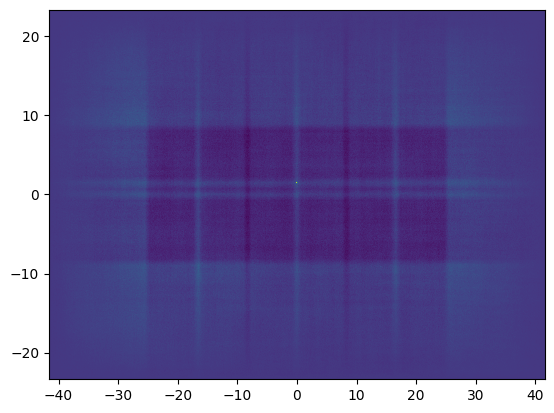

In [4]:
fig,ax =  plt.subplots()
ax.pcolormesh(xlab, ylab, data)

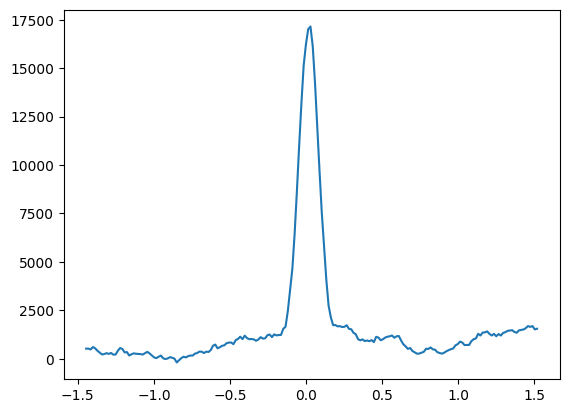

In [14]:
peak = np.max(data)
peak_loc = np.unravel_index(np.argmax(data),data.shape)
window = 100
data_windowed = data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]-window:peak_loc[1]+window]

xfit_xcut = -1* xlab[peak_loc[1]-window:peak_loc[1]+window]
yfit_xcut = data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]]

plt.plot(xfit_xcut,yfit_xcut)
#plt.plot(xlab[peak_loc[0]-window:peak_loc[0]+window], data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]])
#plt.plot(data)

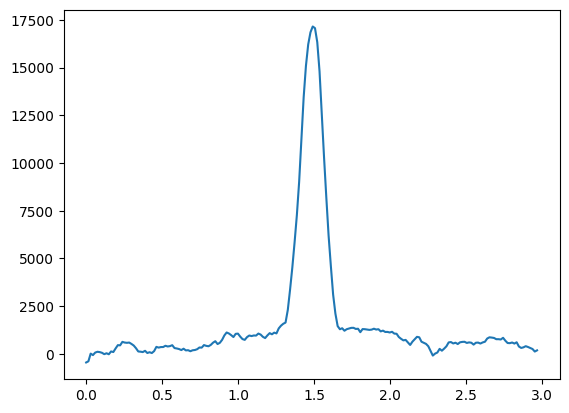

In [6]:
xfit_ycut =ylab[peak_loc[0]-window:peak_loc[0]+window]
yfit_ycut = data[peak_loc[0],peak_loc[1]-window:peak_loc[1]+window]

plt.plot(xfit_ycut,yfit_ycut)


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 200
    # variables        = 3
    chi-square         = 1.4273e+08
    reduced chi-square = 724540.554
    Akaike info crit   = 2701.63588
    Bayesian info crit = 2711.53083
    R-squared          = 0.92692148
[[Variables]]
    amplitude:  2946.68660 +/- 63.2672511 (2.15%) (init = 3876.986)
    center:     0.01901764 +/- 0.00172869 (9.09%) (init = 0.0149)
    sigma:      0.06972724 +/- 0.00172871 (2.48%) (init = 0.0745)
    fwhm:       0.16419510 +/- 0.00407080 (2.48%) == '2.3548200*sigma'
    height:     16859.3781 +/- 361.981938 (2.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5774


c:\Users\ajo5182\AppData\Local\miniconda3\envs\xhcd\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


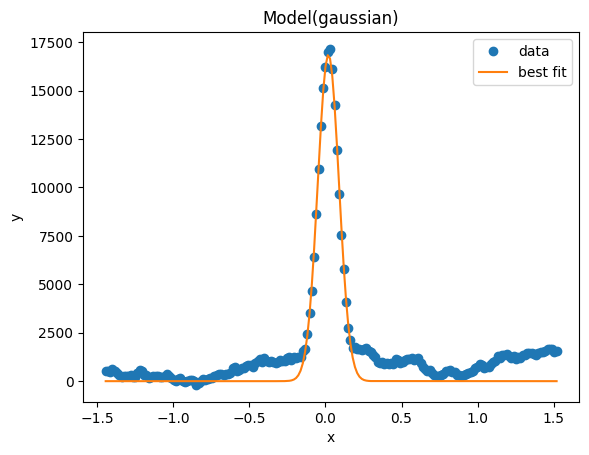

In [7]:
Xmodel  = GaussianModel()
params = Xmodel.guess(yfit_xcut, xfit_xcut)
Xresult = Xmodel.fit(yfit_xcut, params,x = xfit_xcut)
Xresult.plot_fit()
print(Xresult.fit_report())

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude      3386     -inf      inf    53.27     True     None     None
center        1.486     -inf      inf 0.001422     True     None     None
fwhm         0.1843     -inf      inf 0.003348    False 2.3548200*sigma     None
height     1.726e+04     -inf      inf    271.5    False 0.3989423*amplitude/max(1e-15, sigma)     None
sigma       0.07828        0      inf 0.001422     True     None     None


<Parameter 'fwhm', value=np.float64(0.1843239846242024) +/- 0.00335, bounds=[-inf:inf], expr='2.3548200*sigma'>

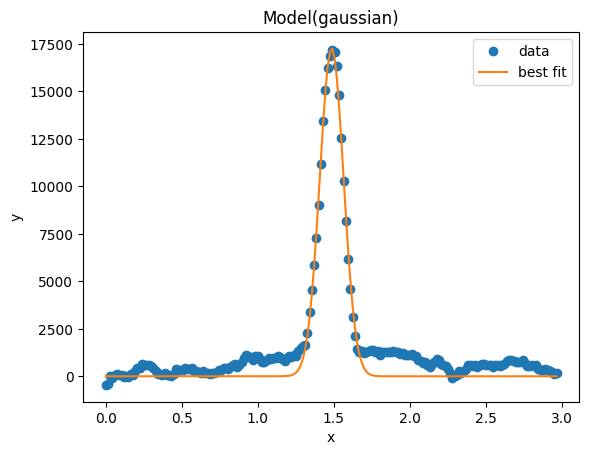

In [8]:
Ymodel  = GaussianModel()
params = Xmodel.guess(yfit_ycut, xfit_ycut)
Yresult = Xmodel.fit(yfit_ycut, params,x = xfit_ycut)
Yresult.plot_fit()
#print(Yresult.fit_report())
Yresult.params.pretty_print()
Yresult.params["fwhm"]

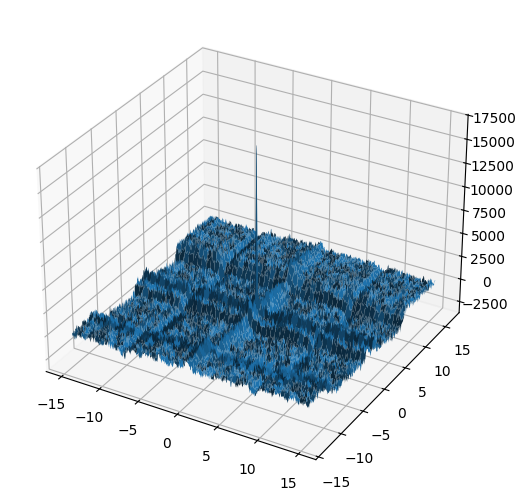

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
X,Y = np.meshgrid(-1* xlab[peak_loc[1]-window:peak_loc[1]+window],ylab[peak_loc[0]-window:peak_loc[0]+window])
ax.plot_surface(X,Y, data_windowed)

In [105]:
p_init = models.Gaussian2D()
fit_p = fitting.TRFLSQFitter()
#with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
#    warnings.filterwarnings('ignore', message='Model is linear in parameters',
#                            category=AstropyUserWarning)
    
p = fit_p(p_init,X,Y,data_windowed)

    The maximum number of function evaluations is exceeded. [astropy.modeling.fitting]
